In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output

In [15]:
frameR = cv2.imread('right.png')
frameL = cv2.imread('left.png')
#Proceed only if the frames have been captured
imgR=cv2.cvtColor(frameL[frameR.shape[0]//2-50:frameR.shape[0]//2+50,frameR.shape[1]//2-50:frameR.shape[1]//2+50], cv2.COLOR_BGR2GRAY)
#imgL = cv2.cvtColor(frameL,cv2.COLOR_BGR2GRAY)
imgL=cv2.cvtColor(frameL[frameL.shape[0]//2-50:frameL.shape[0]//2+50,frameL.shape[1]//2-50:frameL.shape[1]//2+50], cv2.COLOR_BGR2GRAY)      

      
# Detecting keypoints and thier descriptors
sift= cv2.xfeatures2d.SIFT_create()
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)


In [17]:
# Visualize keypoints
imgSift = cv2.drawKeypoints(
    imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("SIFT Keypoints", imgSift)


In [18]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desL, desR, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
ptsL = []
ptsR = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

In [19]:
# Draw the keypoint matches between both pictures

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    imgL, kpL, imgR, kpR, matches[300:500], None, **draw_params)
cv2.imshow("Keypoint matches", keypoint_matches)
cv2.waitKey(5000)


-1

In [20]:

# Calculate the fundamental matrix for the cameras

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
fundamental_matrix, inliers = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC)

# We select only inlier points

ptsL = ptsL[inliers.ravel() == 1]
ptsR = ptsR[inliers.ravel() == 1]

AttributeError: 'NoneType' object has no attribute 'ravel'

In [ ]:
def drawlines(imgLsrc, imgRsrc, lines, ptsLsrc, ptsRsrc):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = imgLsrc.shape
    imgLcolor = cv2.cvtColor(imgLsrc, cv2.COLOR_GRAY2BGR)
    imgRcolor = cv2.cvtColor(imgRsrc, cv2.COLOR_GRAY2BGR)
    
    # Edit: use the same random seed so that two images are comparable!
    
    np.random.seed(0)
    for r, ptL, ptR in zip(lines, ptsLsrc, ptsRsrc):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(imgLcolor, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(imgLcolor, tuple(ptL), 5, color, -1)
        img2color = cv2.circle(imgRcolor, tuple(ptR), 5, color, -1)
    return imgLcolor, imgRcolor

In [21]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image

linesL = cv2.computeCorrespondEpilines(
    ptsR.reshape(-1, 1, 2), 2, fundamental_matrix)
linesL = linesL.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)


# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

linesR = cv2.computeCorrespondEpilines(
    ptsL.reshape(-1, 1, 2), 1, fundamental_matrix)
linesR = linesR.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\calib3d\src\fundam.cpp:861: error: (-215:Assertion failed) F.size() == Size(3,3) in function 'cv::computeCorrespondEpilines'


In [9]:
# Stereo rectification (uncalibrated variant)

print(imgL.shape)
hL, wL = imgL.shape
hR, wR = imgR.shape
_, HL, HR = cv2.stereoRectifyUncalibrated(
    np.float32(ptsL), np.float32(ptsR), fundamental_matrix, imgSize=(wL, hL)
)

(768, 1366)


In [10]:
# Undistort (rectify) the images and save them

imgL_rectified = cv2.warpPerspective(imgL, HL, (wL, hL))
imgR_rectified = cv2.warpPerspective(imgR, HR, (wR, hR))
cv2.imwrite("rectified_left.png", imgL_rectified)
cv2.imwrite("rectified_right.png", imgR_rectified)

True

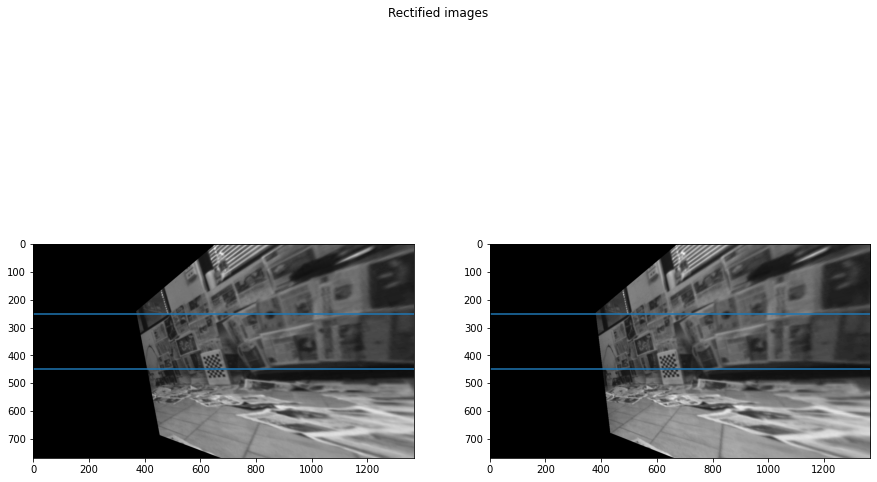

In [11]:
# Draw the rectified images

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(imgL_rectified, cmap="gray")
axes[1].imshow(imgR_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

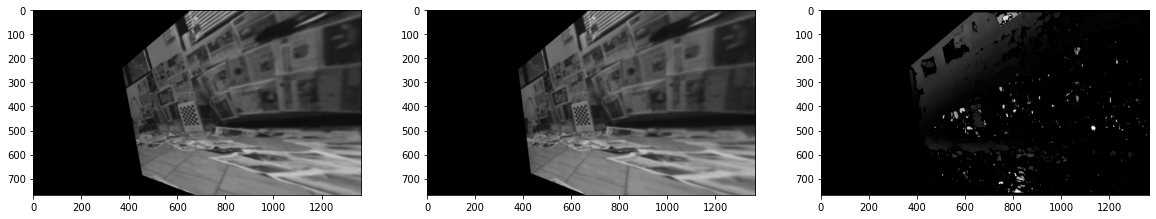

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(imgL_rectified, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.imshow(imgR_rectified, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,3)
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=21)
disparity = stereo.compute(imgR_rectified,imgL_rectified)
plt.imshow(disparity,'gray')
plt.show()

In [48]:

focal = 567.2 
baseline = 92.226
for disparity in range(1,128):
    depth = baseline * focal / disparity
    print(depth)

52310.5872
26155.2936
17436.8624
13077.6468
10462.11744
8718.4312
7472.941028571428
6538.8234
5812.287466666667
5231.05872
4755.507927272727
4359.2156
4023.891323076923
3736.470514285714
3487.37248
3269.4117
3077.0933647058823
2906.1437333333333
2753.1888
2615.52936
2490.980342857143
2377.7539636363636
2274.3733565217394
2179.6078
2092.423488
2011.9456615384615
1937.4291555555556
1868.235257142857
1803.813351724138
1743.68624
1687.4382967741935
1634.70585
1585.169309090909
1538.5466823529412
1494.5882057142858
1453.0718666666667
1413.7996540540541
1376.5944
1341.2971076923077
1307.76468
1275.867980487805
1245.4901714285716
1216.5252837209302
1188.8769818181818
1162.4574933333333
1137.1866782608697
1112.9912170212767
1089.8039
1067.5630040816327
1046.211744
1025.6977882352942
1005.9728307692308
986.9922113207548
968.7145777777778
951.1015854545454
934.1176285714286
917.7296
901.906675862069
886.6201220338984
871.84312
857.5506098360656
843.7191483870968
830.326780952381
817.352925
804.7

In [70]:

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(imgL_rectified, 412, org=(150, 250), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=3, color=(0, 255, 0),thickness=3)
cv2.imshow('imgL_rectified',imgL_rectified)
cv2.waitKey(5000)

TypeError: bad argument type for built-in operation